# Deep Learning

## Restricted Boltzmann machines

Source: http://scikit-learn.org/stable/modules/neural_networks.html

Restricted Boltzmann machines (RBM) ara unsupervised nonlinear feature learners based on a probabilistic model. The features extracted by an RBM or a hierarchy RBMs often give good results when fed into a linear classifier such as linear SVM or a perceptron. RBM can perform effective non-linear feature extraction.

The method gained popularity for initializing deep neural networks with the weights of independent RBMs. This method is known as unsupervised pre-training.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

In [6]:
def nudge_dataset(X,Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8X8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]
    
    shift = lambda x,w: convolve(x.reshape((8,8)), mode = 'constant',
                                    weights=w).ravel()
    X = np.concatenate([X] + 
                      [np.apply_along_axis(shift, 1, X,vector)
                      for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis = 0)
    return X, Y

In [8]:
# Load data
digits = datasets.load_digits()
X = np.array(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X,0) + 0.0001) # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=0)

In [9]:
# Models used
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state = 0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

In [10]:
# Training
# Hyper-parameters. These were set by cross-validation, using GridSearchCV
rbm.learning_rate = 0.6
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000.0

# Trainng RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)

# Training logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, Y_train) 

[BernoulliRBM] Iteration 1, pseudo-likelihood = -23.14, time = 0.50s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -22.26, time = 0.47s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -21.77, time = 0.61s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20.91, time = 0.48s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.05, time = 0.57s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.53, time = 0.47s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.32, time = 0.51s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -19.71, time = 0.47s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.44, time = 0.61s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.08, time = 0.49s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -19.27, time = 0.57s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.70, time = 0.48s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.66, time = 0.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.62, time = 0.48s
[BernoulliRBM] Iteration 15, 

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [12]:
print("Logistic regression using RBM features: \n%s\n" % 
     (metrics.classification_report(Y_test,
                                   classifier.predict(X_test))))

print("Logistic regression using raw pixel features: \n%s\n" % 
     (metrics.classification_report(Y_test,
                                   logistic_classifier.predict(X_test))))

Logistic regression using RBM features: 
             precision    recall  f1-score   support

          0       0.99      0.97      0.98       174
          1       0.87      0.92      0.90       184
          2       0.95      0.94      0.95       166
          3       0.92      0.85      0.88       194
          4       0.97      0.96      0.96       186
          5       0.87      0.83      0.85       181
          6       0.99      0.95      0.97       207
          7       0.93      0.99      0.96       154
          8       0.72      0.83      0.77       182
          9       0.86      0.81      0.83       169

avg / total       0.91      0.90      0.91      1797


Logistic regression using raw pixel features: 
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       174
          1       0.57      0.55      0.56       184
          2       0.72      0.85      0.78       166
          3       0.76      0.74      0.75       194
      

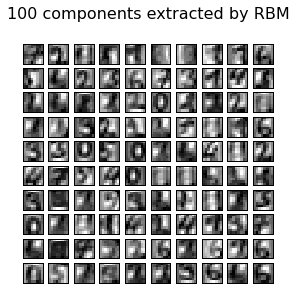

In [14]:
plt.figure(figsize=(4.2,4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((8,8)), cmap = plt.cm.gray_r,
              interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)